In [1]:
import tensorflow as tf
import glob
import shutil
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from sklearn.metrics import accuracy_score 
import zipfile
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import sys
from os import listdir
from os.path import isfile, join


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [67]:
mypath = '/content/drive/MyDrive/PRUEBAS_FINALES/prueba_12'

onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
image_cc = np.empty(len(onlyfiles), dtype=object)
for n in range(0, len(onlyfiles)):
  image_cc[n] = cv2.imread( join(mypath,onlyfiles[n]) )

#image_cc = cv2.imread('/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/fotos_pruebas/Trudeau.jpg')

face_classifier = cv2.CascadeClassifier('/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/Haarcascades/haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/Haarcascades/haarcascade_eye.xml')

  #OJOS
model_direct_eyes = '/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/modeloojos.h5'
modelo_eyes = load_model(model_direct_eyes)

  #BOSTEZOS
model_direct_bost = '/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/modelobostezos.h5'
modelo_bost = load_model(model_direct_bost)

In [68]:
def Cascada(image_cc):

  #IMAGEN OJOS
  image_c = cv2.cvtColor(image_cc, cv2.COLOR_BGR2RGB)

  #IMAGEN BOSTEZOS
  Image_c = cv2.cvtColor(image_cc, cv2.COLOR_BGR2RGB)

  #face_classifier = cv2.CascadeClassifier('/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/Haarcascades/haarcascade_frontalface_default.xml')
  #eye_classifier = cv2.CascadeClassifier('/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/Haarcascades/haarcascade_eye.xml')

  faces = face_classifier.detectMultiScale(image_c, 1.2, 5)

  for (x,y,w,h) in faces:
      cv2.rectangle(image_c,(x,y),(x+w,y+h),(0,255,255), 3)
      #plt.imshow(image_c)
      #cv2.waitKey(0)
      #cv2.destroyAllWindows()

  face_region = image_c[y:y+h, x:x+w]
  eyes = eye_classifier.detectMultiScale(face_region)

  for (eyes_x, eyes_y, eyes_w,eyes_h) in eyes:
          cv2.rectangle(face_region,(eyes_x, eyes_y),(eyes_x + eyes_w, eyes_y + eyes_h), (0,255,0),3)
          #plt.imshow(image_c)
          #cv2.waitKey(0)
    
  #cv2.destroyAllWindows()

  eyes_region=face_region[eyes_y:eyes_y+eyes_h,eyes_x:eyes_x+eyes_w]
  #plt.imshow(eyes_region)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()

  #PREPROCESAMIENTO IMAGEN RED OJOS

  eyes_region_res= cv2.resize(eyes_region,dsize=(224,224), interpolation = cv2.INTER_CUBIC)
  #plt.imshow(eyes_region_res)
  #cv2.waitKey(0)
  np_image_data = np.asarray(eyes_region_res)
  np_final = np.expand_dims(np_image_data,axis=0)
  input_mean = 255
  input_std = 255
  input_data = (np.float32(np_final) - input_mean) / input_std

  #PREPROCESAMIENTO PARA RED DE BOSTEZOS

  image_c_res= cv2.resize(Image_c,dsize=(480,480), interpolation = cv2.INTER_CUBIC)
  #plt.imshow(image_c_res)
  #cv2.waitKey(0)
  np_image_data_b = np.asarray(image_c_res)
  np_final_b = np.expand_dims(np_image_data_b,axis=0)
  input_data_b = (np.float32(np_final_b) - input_mean) / input_std

  #INVOCACION DE MODELOS

  #OJOS
  #model_dir = '/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/modeloojos.h5'
  #modelo = load_model(model_dir)

  #BOSTEZOS
  #model_dir_b = '/content/drive/MyDrive/014_cv2_Faces-and-Eyes-Detection-master/modelobostezos.h5'
  #modelo_b = load_model(model_dir_b)

  #PREDICCIONES

  preds_e=modelo_eyes.predict(input_data)
  preds_e = tf.squeeze(preds_e).numpy()
  preds_eyes = np.argmax(preds_e, axis=-1)

  preds_b=modelo_bost.predict(input_data_b)
  preds_b = tf.squeeze(preds_b).numpy()
  preds_bost = np.argmax(preds_b, axis=-1)


  #print ("prediccion ojos: ", prediccion_id)
  #print ("prediccion bostezos: ", prediccion_id_b)

  return preds_eyes, preds_bost

In [22]:
from time import time

tiempo_inicial = time() 
 
Cascada(image_cc[0])

tiempo_final = time() 
 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion) #En segundos



El tiempo de ejecucion fue: 2.5448663234710693


In [69]:
preds=[]
a=0;
b=0;
c=0;
s=0;
for i in image_cc:
  preds_eyes, preds_bost=Cascada(i) 
 
  if preds_eyes==1:
    a=a+1
    if a>=2:
      print('Puede estar experimentando somnolencia')
      s=1

  elif preds_bost==1:
    b=b+1
    s=1
    if 4<=b<=7:
      print('Puede estar experimentando somnolencia')
      
  else:
    a=0
    b=0
    print('Se encuentra en estado activo, sin signos de somnolencia')
    s=0

  preds.append(s)

Se encuentra en estado activo, sin signos de somnolencia
Se encuentra en estado activo, sin signos de somnolencia
Se encuentra en estado activo, sin signos de somnolencia
Se encuentra en estado activo, sin signos de somnolencia
Se encuentra en estado activo, sin signos de somnolencia
Se encuentra en estado activo, sin signos de somnolencia


In [70]:
#print(preds)
test_dir='/content/drive/MyDrive/PRUEBAS_FINALES/prueba_12_cl'
classes = ['no tiene sueño', 'tiene sueño']

In [71]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=12,
                                                              directory=test_dir,
                                                              class_mode='binary')

Found 6 images belonging to 2 classes.


In [72]:
data_test, label_test = test_data_gen[0]

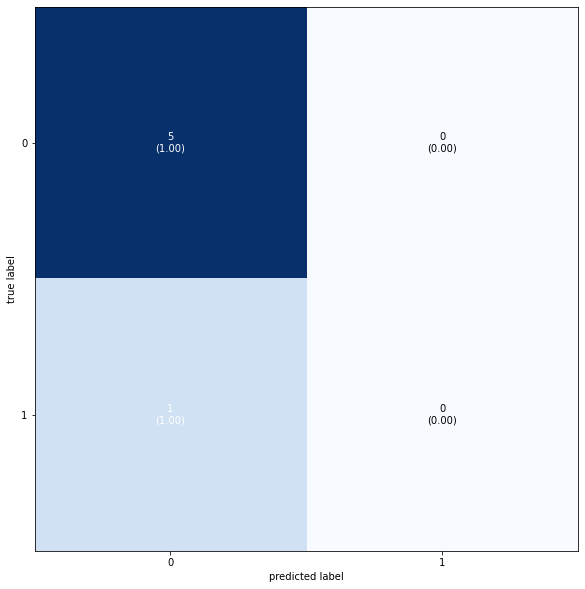

In [73]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
mat= confusion_matrix(label_test, preds)
fig, ax= plot_confusion_matrix(conf_mat= mat, figsize=(10, 10), show_normed=True)

In [ ]:
len(preds)
#len(label_test)
#len(image_cc)

170